# Analyse des commentaires
Dans ce notebook, nous allons regarder en détail les commentaires laissés par les utilisateurs.
Le travail sera divisé en deux parties : Construction du corpus et Début ? d'analyse des fréquences

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import center_score
import seaborn as sns

%load_ext autoreload
%autoreload 2

## Partie 1 : Construction corpus

Afin de construire le corpus, nous allons utiliser la fonction ```corpus_construction``` du fichier _text_filtering.py_ Celle-ci prend en paramètre la taille du corpus souhaité et utilise la BDD _lemmas.csv_ afin de récupérer les fréquences d'apparition de chaque lemma. Pour l'instant, nous gardons les $k$ instances les plus fréquentes, où $k$ représente la taille passée en paramètre.

(proposition de modification: ajouter en paramètre le nombre d'apparition minimum de chaque instance sur l'ensemble des avis ?)

In [2]:
corpus2 = ft.construction_corpus(2000)
# corpus5 = ft.construction_corpus(5000)
# corpus10 = ft.construction_corpus(10000)

In [3]:
lemmas = pd.read_csv("generated_data/lemmas.csv", index_col=0)

## Partie 2 : Analyse des fréquences

Maintenant que nous avons créé nos corpus, nous pouvons comparer les champs lexicaux utilisés sur les avis négatifs et positifs. Pour cela, nous devons d'abord séparer les avis en deux catégories. Il est important de centrer les notes afin d'enlever le biais des utilisateurs sur les notes.

In [4]:
# Construction de la BDD avec avis centrés
avis = pd.read_csv("database_cleaned/avis_clean.csv", index_col = 0)
min_reviews = 10
rev_filter = filter_df(avis, min_reviews)
filtered_centrd_data, _= center_score(rev_filter)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [5]:
folder = "database_cleaned"
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)

In [6]:
# Séparation de la bdd 
positifs = filtered_centrd_data[filtered_centrd_data['Rating'] >=0][['Comment title', 'Comment body']].copy()
negatifs = filtered_centrd_data[filtered_centrd_data['Rating'] <0][['Comment title', 'Comment body']].copy()

In [7]:
print("Nombre d'avis negatif", len(negatifs)/len(filtered_centrd_data))
print("Nombre d'avis positif", len(positifs)/len(filtered_centrd_data))

Nombre d'avis negatif 0.43073353153843763
Nombre d'avis positif 0.5692664684615624


In [8]:
# lem = pd.read_csv("generated_data/lemmas.csv")[['Comment line', 'Lemma']]
# lem['Lemma'] = lem['Lemma'].apply(lambda val : " " if type(val) != str else val )
# lem = lem.groupby(by='Comment line').apply(lambda row : " ".join(row["Lemma"])) 
# lem = lem.to_frame()
# lem.columns = ['Comment']
# lem.to_csv("generated_data/avis_lemmatized.csv")

À partir de là, nous pouvons appliquer la fonction ```word_freq``` qui calcul la fréquence de chaque lemma dans chaque dataframe des avis.

In [9]:
fpos = ft.words_freq(positifs, corpus2)
fneg = ft.words_freq(negatifs, corpus2)

In [10]:
fpos = fpos.sort_values(by=['Freq'], ascending = False)
fneg = fneg.sort_values(by=['Freq'], ascending = False)

Text(0.5, 1.0, "Fréquence des Lemmas par type d'avis : corpus 2000")

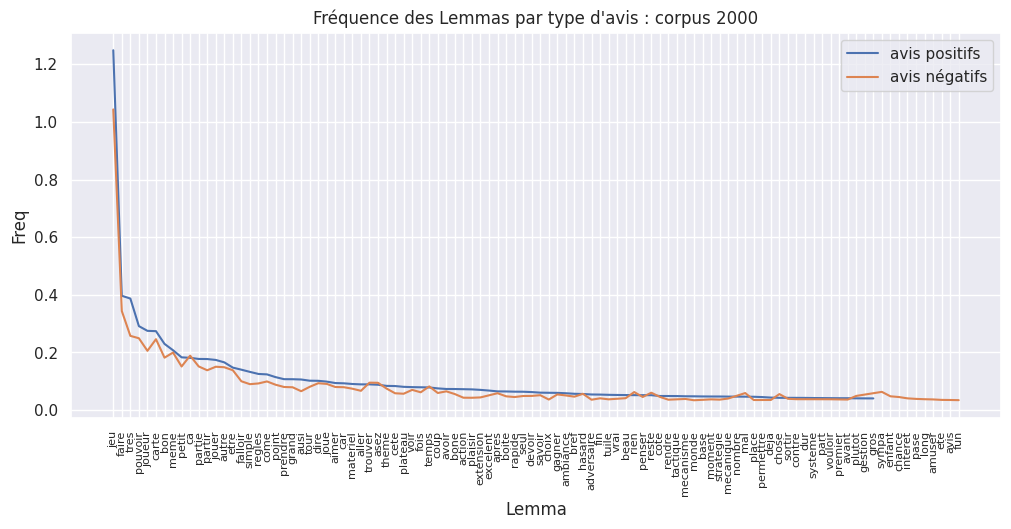

In [11]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fpos.head(90),x='Lemma',y='Freq',label='avis positifs')
ax = sns.lineplot(fneg.head(90),x='Lemma',y='Freq',label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Fréquence des Lemmas par type d'avis : corpus 2000")

On peut remarquer qu'à certains endroit, il existe des écarts de fréquence beaucoup plus prononcés qu'à d'autres. Afin de mieux les voir, nous pouvons utiliser la fonction ```diff_freq```. Elle retourne un dataframe avec, pour chaque lemma $l$, la différence entre la fréquence de $l$ dans les avis positifs et celle dans les avis négatifs. Ainsi, la différence de fréquence sera positive si $l$ apparaît plus souvent dans les avis positifs et que négatifs, et vice versa.

Le DataFrame retourné est trié par différence de fréquence décroissante.

In [12]:
fdiff = ft.diff_freq(fpos,fneg) # si valeur >= 0, alors + grande frequence dans fpos que fneg 
fdiff

,Lemma,Freq differency
30673,jeu,0.205292
57127,tres,0.129466
31092,joueur,0.069317
22318,faire,0.052982
21543,excelent,0.050154
...,...,...
48505,repetitif,-0.013907
34669,manque,-0.014326
17428,domage,-0.014892
29848,interet,-0.018720


On remarque que pour 2000 mots, tous les mots dans fpos sont aussi dans fneg

Text(0.5, 1.0, 'Différence de fréquences : 50 mots + notables avis positifs : corpus 2000')

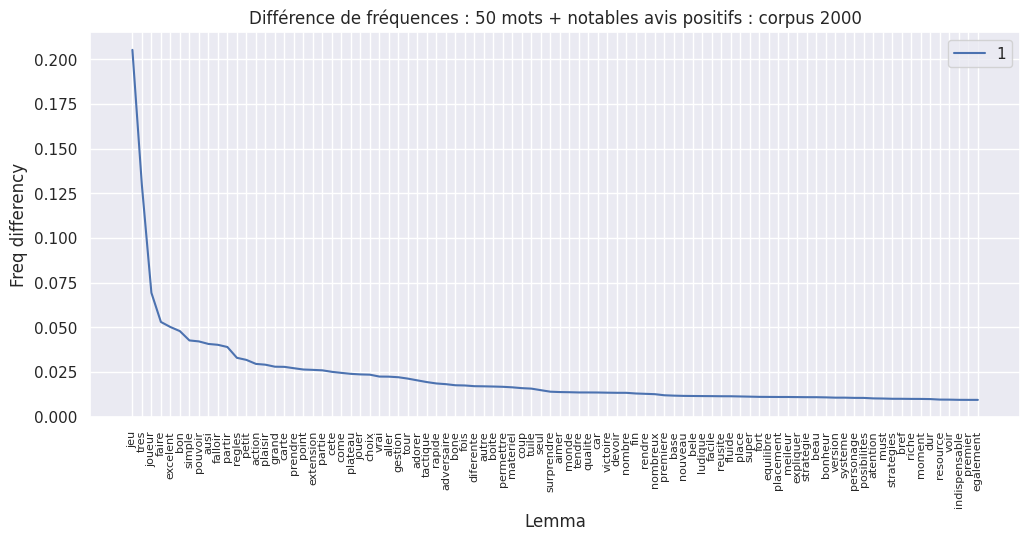

In [13]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff.head(90), x='Lemma',y='Freq differency', label='1')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquences : 50 mots + notables avis positifs : corpus 2000")

Text(0.5, 1.0, 'Différence de fréquence : 50 mots + notables avis négatifs : corpus 2000')

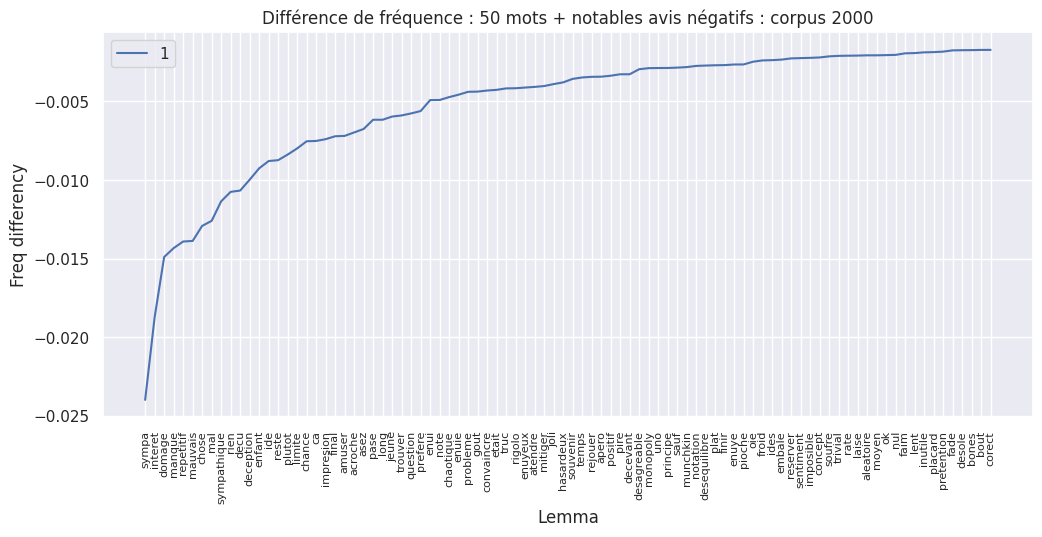

In [14]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff.tail(90)[::-1], x='Lemma',y='Freq differency', label='1')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence : 50 mots + notables avis négatifs : corpus 2000")

Zoom sur les différences de fréquence


Text(0.5, 1.0, 'Différence de fréquence sur les pires mots : corpus 2000')

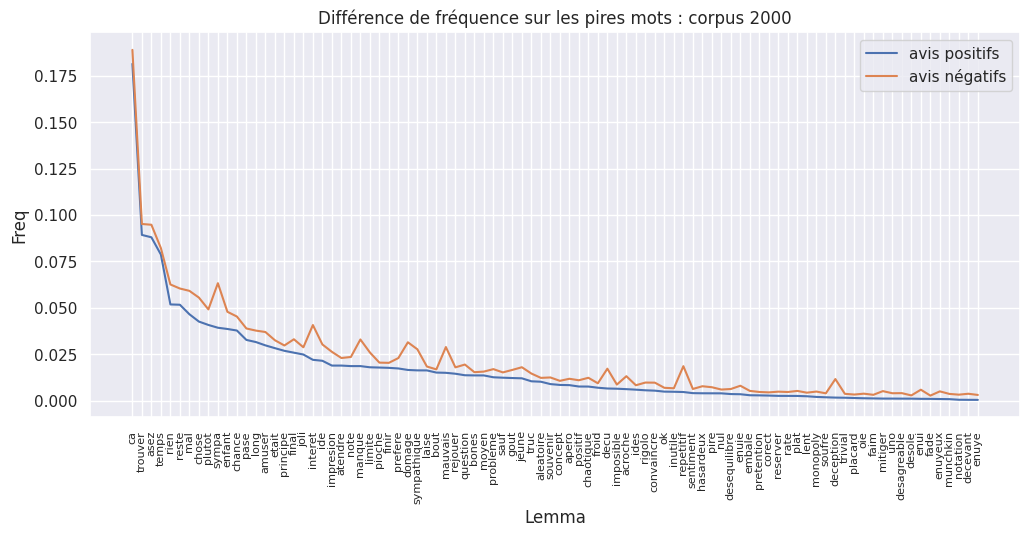

In [15]:
lemmas_neg = fdiff.tail(90)['Lemma'].to_numpy()
pos_tail = fpos[fpos['Lemma'].isin(lemmas_neg)]
neg_tail = fneg[fneg['Lemma'].isin(lemmas_neg)]

ax = sns.lineplot(pos_tail, x='Lemma', y='Freq', label='avis positifs')
ax = sns.lineplot(neg_tail, x='Lemma', y='Freq', label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence sur les pires mots : corpus 2000")

Text(0.5, 1.0, 'Différence de fréquence sur les meilleurs mots : corpus 2000')

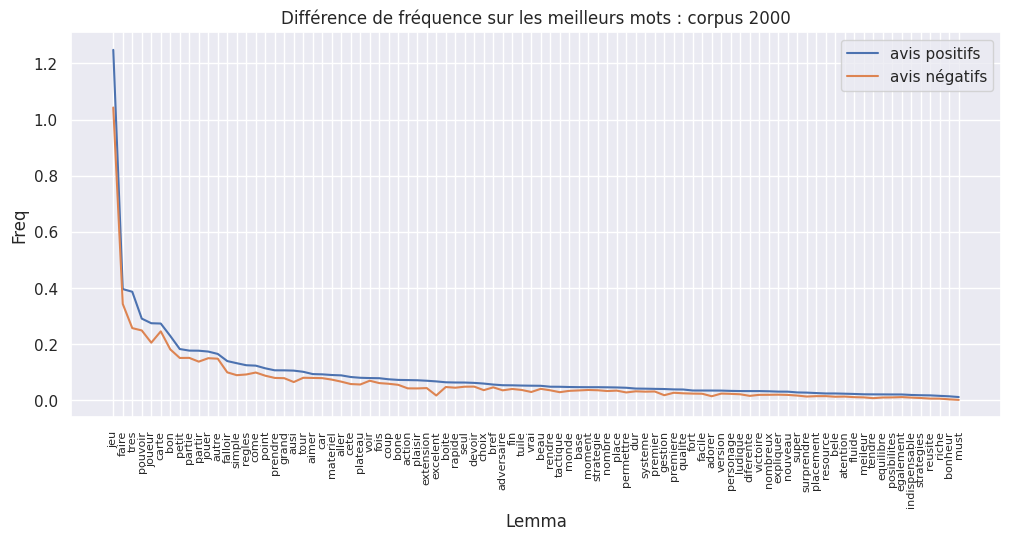

In [100]:
lemmas_neg = fdiff.head(90)['Lemma'].to_numpy()
pos_head = fpos[fpos['Lemma'].isin(lemmas_neg)]
neg_head = fneg[fneg['Lemma'].isin(lemmas_neg)]

ax = sns.lineplot(pos_head, x='Lemma', y='Freq', label='avis positifs')
ax = sns.lineplot(neg_head, x='Lemma', y='Freq', label='avis négatifs')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Différence de fréquence sur les meilleurs mots : corpus 2000")

Visualisation par types de mots

In [16]:
lemmas_sp = lemmas[~lemmas["Lemma"].isna()]
lemmas_sp = lemmas_sp[lemmas_sp['Part of speech'].isin(['ADJ', 'NOM', "VER:infi","VER:pper", "VER:pres"])]
lemmas_sp_np = lemmas_sp[['Lemma', "Part of speech"]].to_numpy()

In [17]:
lemma_speech = lemmas_sp[['Lemma', 'Part of speech']]
lemma_speech['Part of speech'].unique()

array(['NOM', 'ADJ', 'VER:infi', 'VER:pper', 'VER:pres'], dtype=object)

In [18]:
# get only verbs
lemma_verb = lemma_speech[lemma_speech['Part of speech'].isin(['VER:infi', 'VER:pper', 'VER:pres'])]
fdiff_verb = fdiff[fdiff['Lemma'].isin(lemma_verb['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_verb['Lemma'].unique()

array(['rejouer', 'revivre', 'lorsqu', ..., 'rapidesjoli', 'adversaitre',
       'resoue'], dtype=object)

In [19]:
fdiff_verb.shape

(388, 2)

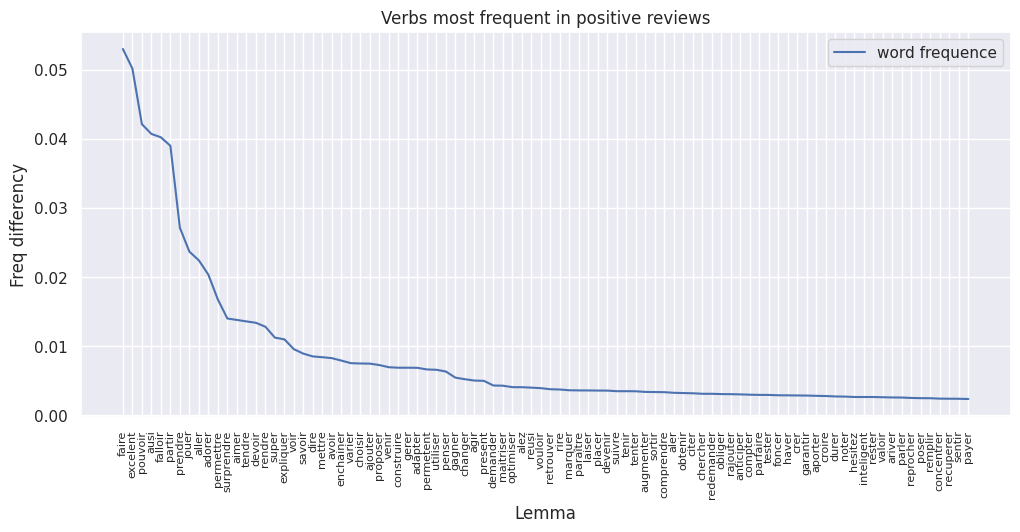

In [20]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_verb.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Verbs most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

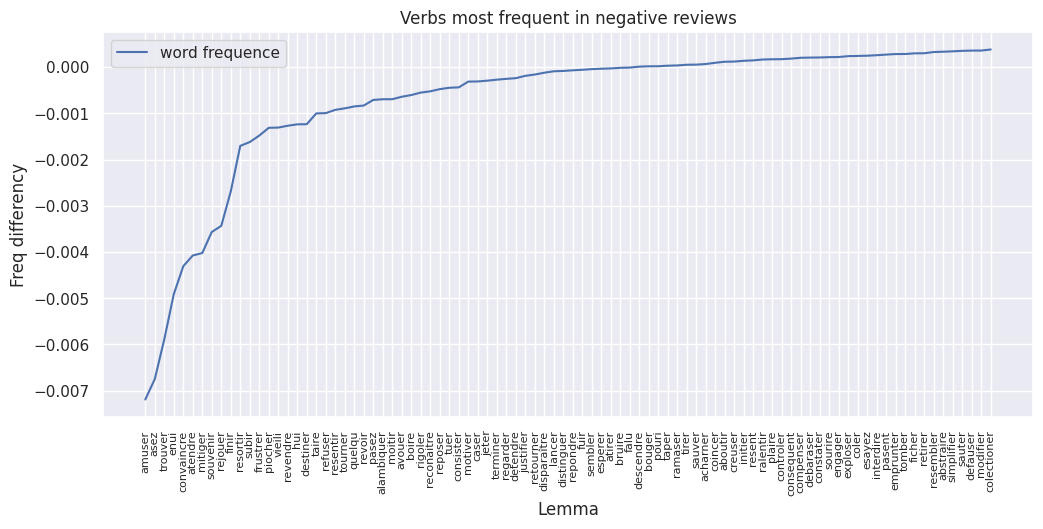

In [21]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_verb.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Verbs most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

In [22]:
# get only adj
lemma_adj = lemma_speech[lemma_speech['Part of speech'].isin(['ADJ'])]
fdiff_adj = fdiff[fdiff['Lemma'].isin(lemma_adj['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_adj['Lemma'].unique()

array(['bon', 'joli', 'sensible', ..., 'formaidable', 'jaux', 'bauzales'],
      dtype=object)

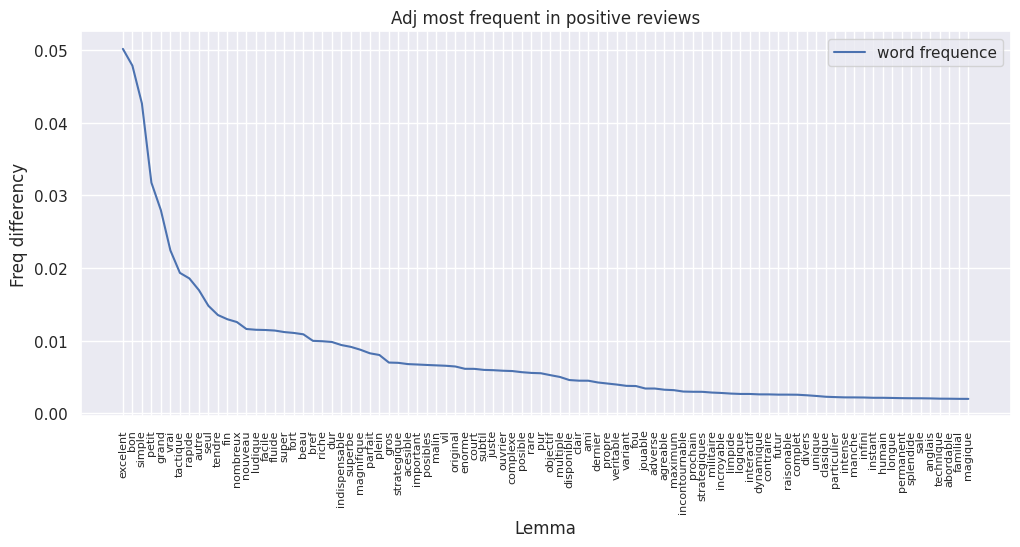

In [23]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_adj.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Adj most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

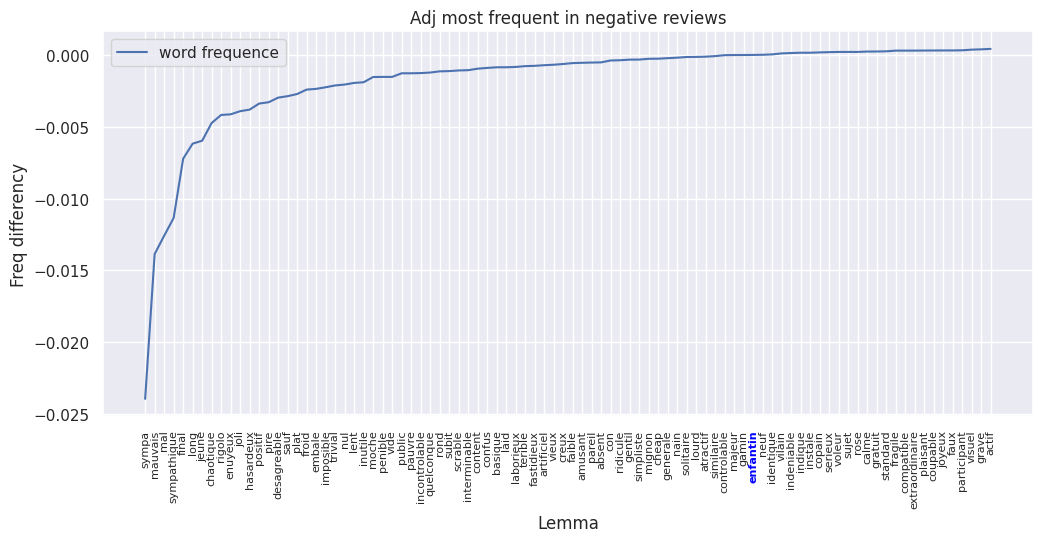

In [24]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_adj.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Adj most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

# color one label
for label, position in zip(ax.get_xticklabels(), ax.get_xticks()):
    if label.get_text() == 'enfantin':
        label.set_color("blue")
        label.set_fontweight('bold')

In [25]:
# get only nom
lemma_nom = lemma_speech[lemma_speech['Part of speech'].isin(['NOM'])]
fdiff_nom = fdiff[fdiff['Lemma'].isin(lemma_nom['Lemma'].unique())].sort_values(by=['Freq differency'], ascending=False)
lemma_nom['Lemma'].unique()

array(['voyage', 'aile', 'papilon', ..., 'defensebref', 'acrochele',
       'miral'], dtype=object)

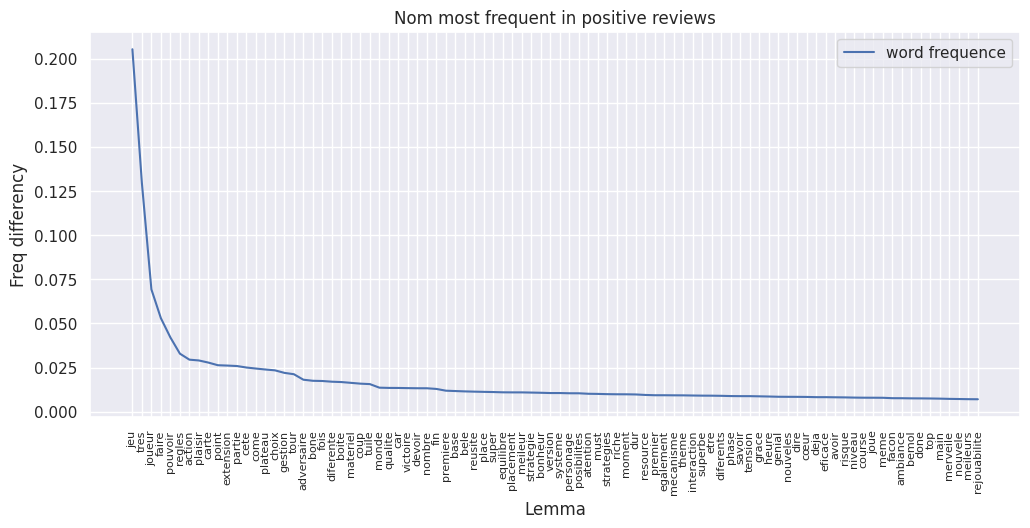

In [26]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_nom.head(90), x='Lemma',y='Freq differency', label='word frequence')
plt.title("Nom most frequent in positive reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

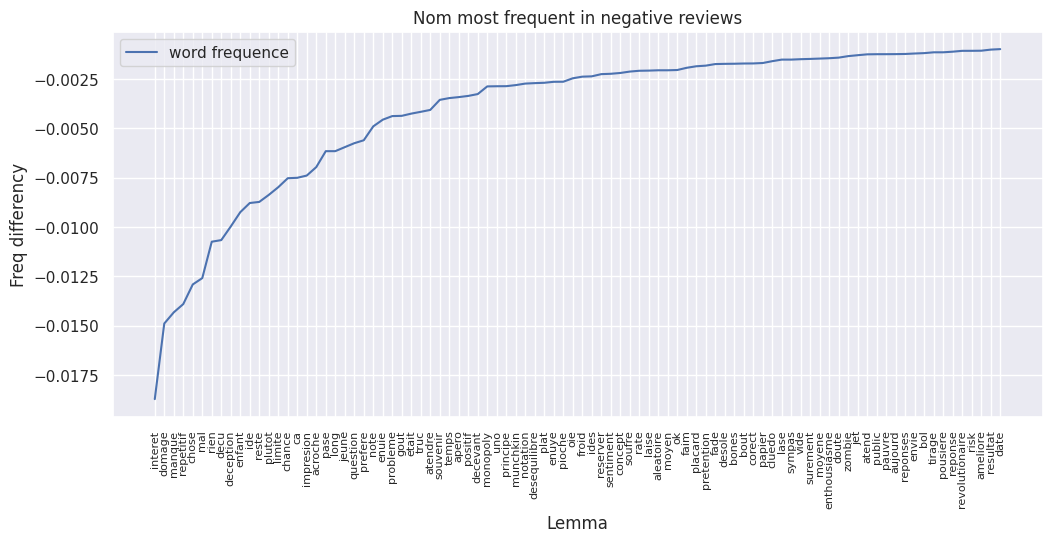

In [27]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(fdiff_nom.tail(90)[::-1], x='Lemma',y='Freq differency', label='word frequence')
plt.title("Nom most frequent in negative reviews")
ax.tick_params(axis='x', rotation=90, labelsize=8)

In [28]:
# vocabulary + - difference
fdiff[fdiff["Freq differency"] >0].shape, fdiff[fdiff["Freq differency"] <=0].shape

((1663, 2), (337, 2))

### See most and less rated games vocabulary 

In [29]:
# sort games by ratings rank
rank_game = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().sort_values(by="Rating", ascending=False)
rank_game.head(), rank_game.tail()

(            Rating
 Game id           
 7733     10.000000
 6678      9.833333
 8821      9.800000
 9669      9.700000
 9210      9.600000,
            Rating
 Game id          
 440      2.545455
 5476     2.481481
 2099     2.430000
 4916     2.390000
 1928     2.000000)

In [77]:
# rev_filter[rev_filter["Game id"] == 1928]

In [101]:
top_5 = rev_filter[rev_filter["Game id"].isin(rank_game.head(6).index)][["Game id", "Comment body"]]
top_5['Comment body'] = top_5['Comment body'].apply(lambda row : row.split())
top_5 = top_5.explode(column='Comment body')
top_5 = top_5[top_5["Comment body"].isin(corpus2)]
top_5

,Game id,Comment body
19196,2583,mal
19196,2583,extension
19196,2583,content
19196,2583,avoir
19197,2583,avoir
...,...,...
104227,9669,jeu
104227,9669,monde
104227,9669,un
104227,9669,jeu


In [102]:
# word frequencies for these games
def word_frequencies(group):
    words = group['Comment body'].values
    val, nb = np.unique(words, return_counts=True)
    return pd.Series(val, index=nb/np.sum(nb))

result = top_5.groupby('Game id').apply(word_frequencies).reset_index(name="word").rename(columns={'level_1': 'freq'})
result

/tmp/ipykernel_3924/40335655.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = top_5.groupby('Game id').apply(word_frequencies).reset_index(name="word").rename(columns={'level_1': 'freq'})


,Game id,freq,word
0,2583,0.007692,acheter
1,2583,0.007692,acquérir
2,2583,0.007692,aller
3,2583,0.007692,amateur
4,2583,0.007692,augmenter
...,...,...,...
549,9669,0.021277,version
550,9669,0.010638,victoire
551,9669,0.005319,vie
552,9669,0.010638,voir


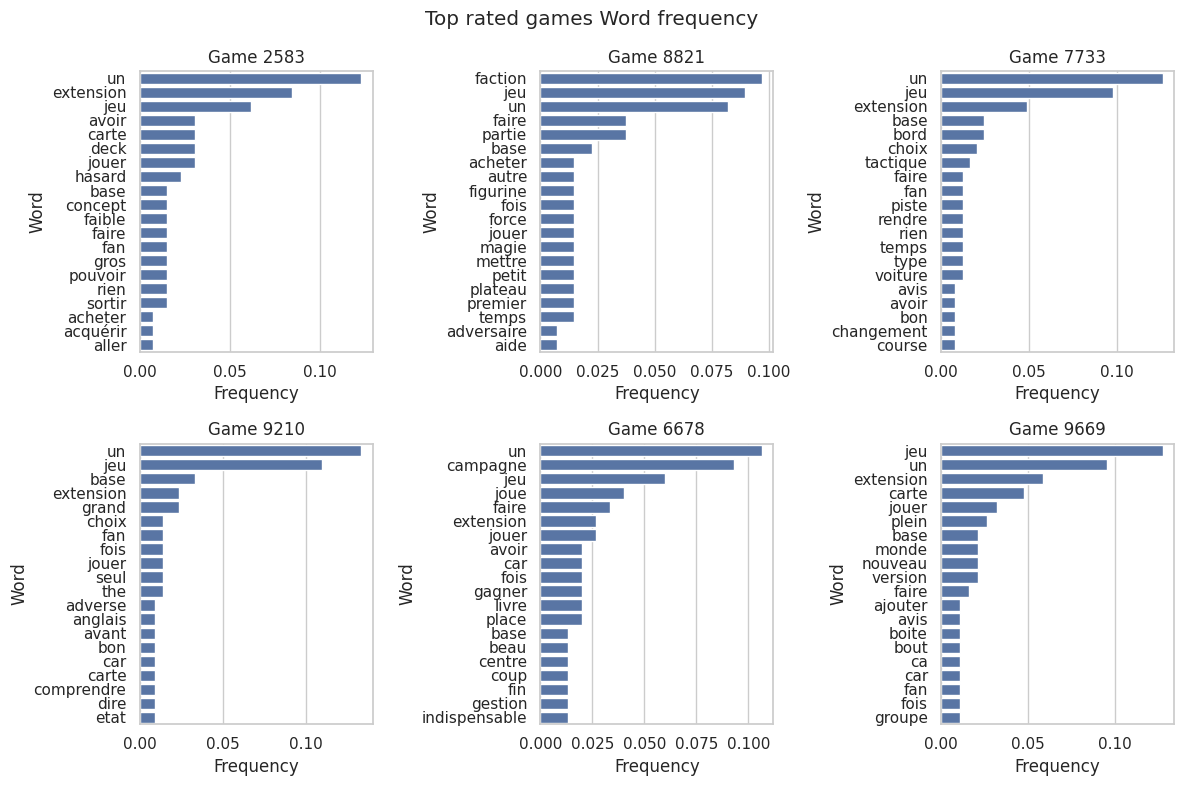

In [103]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, game_id in enumerate(top_5['Game id'].unique()):
    game_words = result[result['Game id'] == game_id][["word", "freq"]]
    
    ax = axes[i // 3, i % 3]
    sns.barplot(x='freq', y='word', data=game_words.nlargest(20, columns="freq"), ax=ax)

    ax.set_title(f"Game {game_id}")
    ax.set_ylabel('Word')
    ax.set_xlabel('Frequency')

fig.suptitle('Top rated games Word frequency')
plt.tight_layout()
plt.show()

In [104]:
for id in result["Game id"].unique():
    print(id, jeux_clean.iloc[id]["Type"]," : ", jeux_clean.iloc[id]["Game name website"])

2583 nan  :  dominion-age-des-tenebres-0
6678 Jeux de plateau  :  memoire-44-carnets-de-campagne-vol-1
7733 nan  :  rallyman-dirt
8821 Jeu de carte à collectionner|Jeux de cartes  :  summoner-wars-le-royaume-dechu
9210 Jeux de cartes  :  the-new-era
9669 Jeux de plateau  :  twilight-imperium-shattered-empire


We can categorize the games that have NaN categories, 

-> rallyman-dirt is about cars and race

-> dominion-age-des-tenebres-0 games with cards, kingdoms, battle, is an extension

In [105]:
res_clean = result.drop(result[result["word"].isin(['un', 'jeu', 'jouer', 'joue', 'faire'])].index)
res_clean.shape, result.shape

((528, 3), (554, 3))

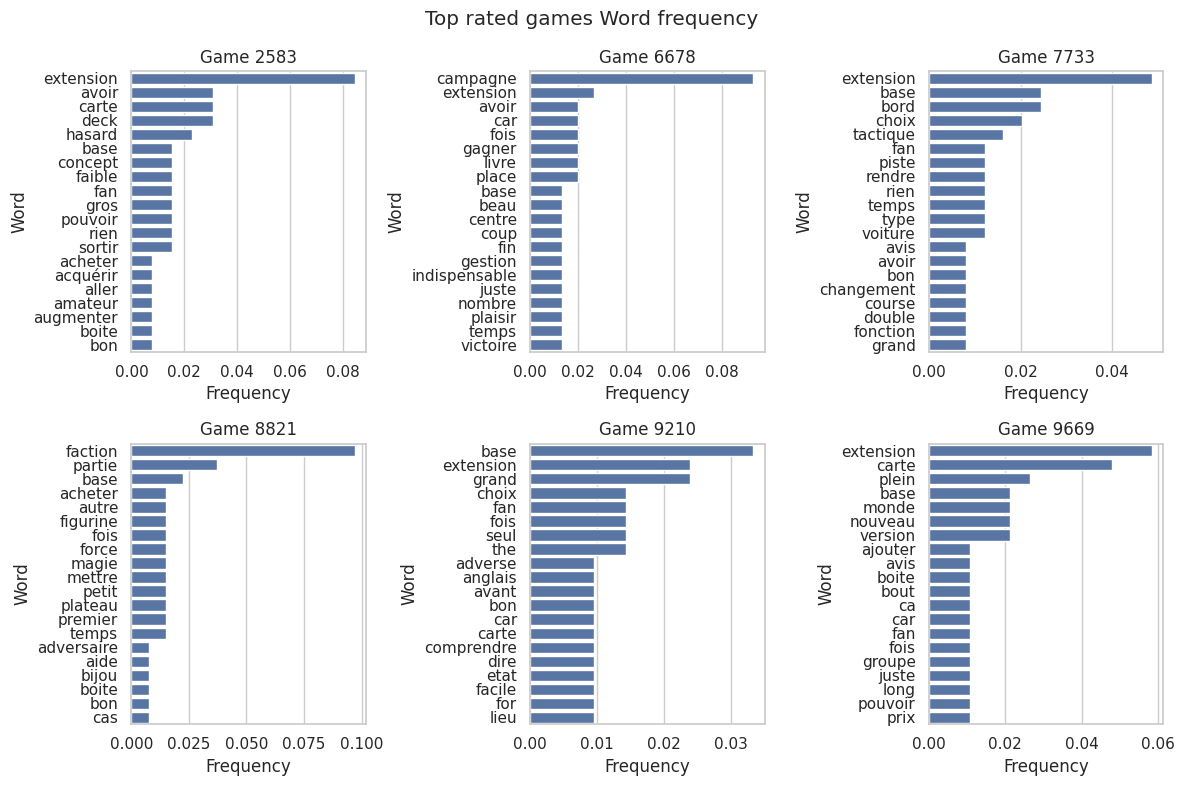

In [106]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, game_id in enumerate(result['Game id'].unique()):
    game_words = res_clean[res_clean['Game id'] == game_id][["word", "freq"]]
    
    ax = axes[i // 3, i % 3]
    sns.barplot(x='freq', y='word', data=game_words.nlargest(20, columns="freq"), ax=ax)

    ax.set_title(f"Game {game_id}")
    ax.set_ylabel('Word')
    ax.set_xlabel('Frequency')

fig.suptitle('Top rated games Word frequency')
plt.tight_layout()
plt.show()

In [107]:
word_pos = fdiff[fdiff['Freq differency'] >= 0]
word_neg = fdiff[fdiff['Freq differency'] < 0]
word_pos.shape, word_neg.shape

((1663, 2), (337, 2))

In [108]:
# percentage of words that are in + vocabulary
result.groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x))

Game id
2583    0.826667
6678    0.893333
7733    0.842520
8821    0.860759
9210    0.880734
9669    0.865169
Name: word, dtype: float64

In [109]:
# check by category of words
print("Percentage of + words among NOM")
print(result[result['word'].isin(lemma_nom['Lemma'])].groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x)))
print("\nPercentage of + words among ADJ")
print(result[result['word'].isin(lemma_adj['Lemma'])].groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x)))
print("\nPercentage of + words among VERB")
print(result[result['word'].isin(lemma_verb['Lemma'])].groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x)))

Percentage of + words among NOM
Game id
2583    0.780000
6678    0.870370
7733    0.818182
8821    0.826923
9210    0.878378
9669    0.862069
Name: word, dtype: float64

Percentage of + words among ADJ
Game id
2583    0.777778
6678    0.909091
7733    0.846154
8821    0.888889
9210    0.818182
9669    0.941176
Name: word, dtype: float64

Percentage of + words among VERB
Game id
2583    0.944444
6678    0.937500
7733    0.920000
8821    0.888889
9210    0.875000
9669    0.750000
Name: word, dtype: float64


In [84]:
# worst games
worst_5 = rev_filter[rev_filter["Game id"].isin(rank_game.tail(6).index)][["Game id", "Comment body"]]
worst_5['Comment body'] = worst_5['Comment body'].apply(lambda row : row.split())
worst_5 = worst_5.explode(column='Comment body')
worst_5 = worst_5[worst_5["Comment body"].isin(corpus2)]
worst_5

,Game id,Comment body
56094,1928,proposer
56094,1928,un
56094,1928,jeu
56094,1928,or
56095,1928,jeu
...,...,...
138270,3784,lieu
138270,3784,carte
138270,3784,un
138270,3784,jeu


In [85]:
result = worst_5.groupby('Game id').apply(word_frequencies).reset_index(name="word").rename(columns={'level_1': 'freq'})
result

/tmp/ipykernel_3924/4156688079.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = worst_5.groupby('Game id').apply(word_frequencies).reset_index(name="word").rename(columns={'level_1': 'freq'})


,Game id,freq,word
0,440,0.010989,adversaire
1,440,0.010989,avance
2,440,0.010989,avant
3,440,0.010989,avis
4,440,0.021978,avoir
...,...,...,...
399,5476,0.006211,tuer
400,5476,0.006211,type
401,5476,0.142857,un
402,5476,0.012422,version


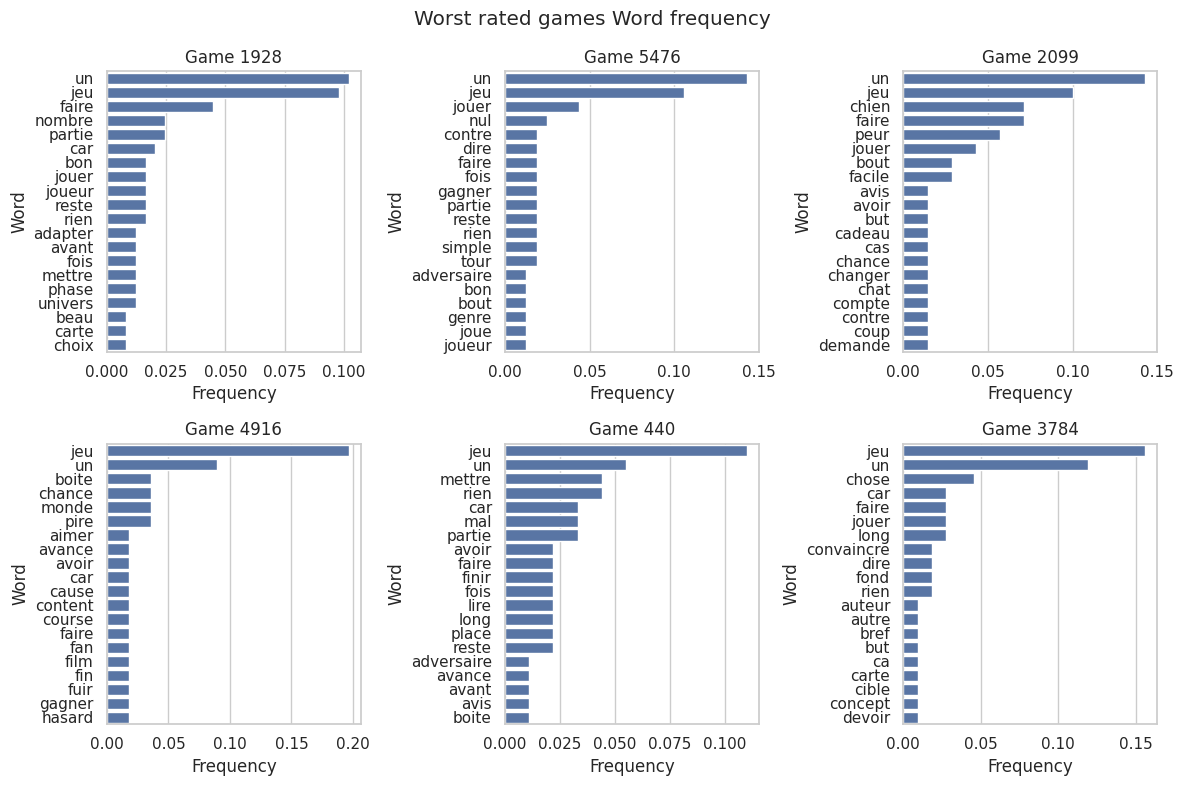

In [88]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, game_id in enumerate(worst_5['Game id'].unique()):
    game_words = result[result['Game id'] == game_id][["word", "freq"]]
    
    ax = axes[i // 3, i % 3]
    sns.barplot(x='freq', y='word', data=game_words.nlargest(20, columns="freq"), ax=ax)

    ax.set_title(f"Game {game_id}")
    ax.set_ylabel('Word')
    ax.set_xlabel('Frequency')

fig.suptitle('Worst rated games Word frequency')
plt.tight_layout()
plt.show()

In [87]:
for id in result["Game id"].unique():
    print(id, jeux_clean.iloc[id]["Type"]," : ", jeux_clean.iloc[id]["Game name website"])

440 Jeux de cartes  :  ana-contre-corax
1928 Jeux de cartes|Contes, Mythes & Légendes|Médiéval-fantastique  :  conan-le-jeu-de-cartes
2099 nan  :  croc-dog
3784 Jeux de cartes  :  halloween
4916 nan  :  la-guerre-des-etoiles
5476 Jeu de logique  :  le-morpion


In [89]:
res_clean = result.drop(result[result["word"].isin(['un', 'jeu', 'jouer', 'joue', 'faire'])].index)
res_clean.shape, result.shape

((378, 3), (404, 3))

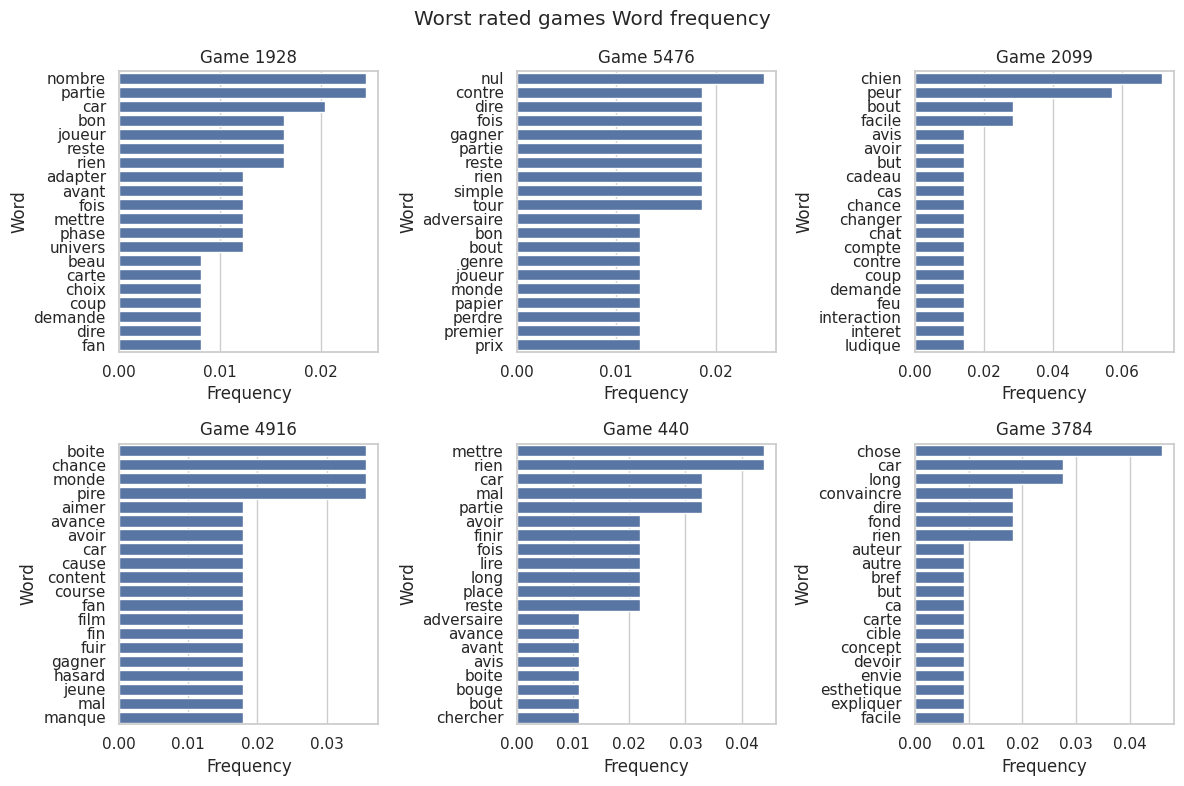

In [90]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, game_id in enumerate(worst_5['Game id'].unique()):
    game_words = res_clean[res_clean['Game id'] == game_id][["word", "freq"]]
    
    ax = axes[i // 3, i % 3]
    sns.barplot(x='freq', y='word', data=game_words.nlargest(20, columns="freq"), ax=ax)

    ax.set_title(f"Game {game_id}")
    ax.set_ylabel('Word')
    ax.set_xlabel('Frequency')

fig.suptitle('Worst rated games Word frequency')
plt.tight_layout()
plt.show()

In [91]:
# percentage of words that are in + vocabulary
result.groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x))

Game id
440     0.758621
1928    0.784000
2099    0.700000
3784    0.707692
4916    0.736842
5476    0.743590
Name: word, dtype: float64

In [98]:
# check by category of words
print("Percentage of + words among NOM")
print(result[result['word'].isin(lemma_nom['Lemma'])].groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x)))
print("\nPercentage of + words among ADJ")
print(result[result['word'].isin(lemma_adj['Lemma'])].groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x)))
print("\nPercentage of + words among VERB")
print(result[result['word'].isin(lemma_verb['Lemma'])].groupby("Game id")["word"].apply(lambda x : x.isin(word_pos['Lemma']).sum()/len(x)))

Percentage of + words among NOM
Game id
440     0.739130
1928    0.797297
2099    0.620690
3784    0.700000
4916    0.750000
5476    0.705882
Name: word, dtype: float64

Percentage of + words among ADJ
Game id
440     0.666667
1928    0.708333
2099    0.666667
3784    0.750000
4916    0.500000
5476    0.800000
Name: word, dtype: float64

Percentage of + words among VERB
Game id
440     0.857143
1928    0.825000
2099    1.000000
3784    0.733333
4916    0.857143
5476    0.882353
Name: word, dtype: float64


In [282]:
# take mean of a game and compare the percentage of pos (>mean) and neg (<mean) reviews -> not very significant
def perc_mean_rev(df, corpus, pos_corp, neg_corp, verbose=False):
    """df (not centered) contains columns 'Comment body' for 1 game 
    return percentage of positive words in positive review (for neg, 1 - value)
    and percentage of negative words in negative review (for pos, 1 - value) 
    """
    df.loc[:,"Comment body"] = df["Comment body"].apply(lambda x : x.split())
    if verbose : print("Mean Rating", df['Rating'].mean())
    df.loc[:,'Rating'] -= df['Rating'].mean()
    if verbose : print("Number of positive review", len(df[df['Rating'] >= 0])/len(df), "\nNumber of negative review", len(df[df['Rating'] < 0])/len(df))

    tokens = df["Comment body"].explode()
    tokens = tokens[tokens.isin(corpus)] # keep corpus words
    freq_pos = tokens.isin(pos_corp).sum()
    freq_neg = tokens.isin(neg_corp).sum()
    if verbose : 
        print("Number of positif word in positive comments", freq_pos/(freq_pos + freq_neg))
        print("Number of negatif word in negativ comments", freq_neg/(freq_pos + freq_neg))

    return freq_pos/(freq_pos + freq_neg), freq_neg/(freq_pos + freq_neg)

pos_adj, neg_adj = lemma_adj[lemma_adj['Lemma'].isin(word_pos['Lemma'])].drop_duplicates()['Lemma'], lemma_adj[lemma_adj['Lemma'].isin(word_neg['Lemma'])].drop_duplicates()['Lemma']
pos_verb, neg_verb = lemma_verb[lemma_verb['Lemma'].isin(word_pos['Lemma'])].drop_duplicates()['Lemma'], lemma_verb[lemma_verb['Lemma'].isin(word_neg['Lemma'])].drop_duplicates()['Lemma']
pos_nom, neg_nom = lemma_nom[lemma_nom['Lemma'].isin(word_pos['Lemma'])].drop_duplicates()['Lemma'], lemma_nom[lemma_nom['Lemma'].isin(word_neg['Lemma'])].drop_duplicates()['Lemma']

In [284]:
perc_mean_rev(avis[avis["Game id"] == 6179][['Comment body', "Rating"]], corpus2, pos_adj, neg_adj, verbose=True)

Mean Rating 7.5
Number of positive review 0.5909090909090909 
Number of negative review 0.4090909090909091
Number of positif word in positive comments 0.7894736842105263
Number of negatif word in negativ comments 0.21052631578947367


(0.7894736842105263, 0.21052631578947367)

In [285]:
perc_mean_rev(avis[avis["Game id"] == 3600][['Comment body', "Rating"]], corpus2, pos_adj, neg_adj, verbose=True)

Mean Rating 3.3333333333333335
Number of positive review 0.5333333333333333 
Number of negative review 0.4666666666666667
Number of positif word in positive comments 0.6101694915254238
Number of negatif word in negativ comments 0.3898305084745763


(0.6101694915254238, 0.3898305084745763)

In [291]:
avg_posw_rev = 0
avg_negw_rev = 0

# average on all words

for id_game in filtered_centrd_data["Game id"].unique():
    pos_w, neg_w = perc_mean_rev(avis[avis["Game id"] == id_game][['Comment body', "Rating"]], corpus2, word_pos['Lemma'], word_neg['Lemma'])
    avg_posw_rev, avg_negw_rev = avg_posw_rev + pos_w, avg_negw_rev + neg_w

avg_posw_rev/filtered_centrd_data["Game id"].unique().shape[0], avg_negw_rev/filtered_centrd_data["Game id"].unique().shape[0]

(0.8694400258856753, 0.13055997411432368)

In [362]:
# given a user and a rated game -> if rated > mean = liked, if rated < mean = disliked
# print the percentage + and - words for the 2 groups of games

def user_vocab(id, df, corpus, pos_corp, neg_corp, verbose = False):
    """ df with centered ratings, columns : "Rating", "Comment body", "Game id"
    calculate the frequence of words in neg and pos comments 

    return percentage of positive (resp. neg) words for positive (resp. neg) reviews
    """
    pos_rev, neg_rev = df[df["Rating"] >= 0]["Comment body"].apply(lambda x: x.split()), df[df["Rating"] < 0]["Comment body"].apply(lambda x: x.split())
    # if len(pos_rev) == 0 or len(neg_rev) == 0: # case all rating = 0
    #     return
    tok_pos, tok_neg = pos_rev.explode(), neg_rev.explode()
    tok_pos, tok_neg = tok_pos[tok_pos.isin(corpus)], tok_neg[tok_neg.isin(corpus)] # tokens from +- comments that are in the corpus      
    
    # we see the percentage of these words in the +- corp
    if verbose:
        print("Positive reviews")
        print("Percentage of positive and negative words", tok_pos.isin(pos_corp).sum()/len(tok_pos), tok_pos.isin(neg_corp).sum()/len(tok_pos))
        print("Negative reviews")
        print("Percentage of positive and negative words", tok_neg.isin(pos_corp).sum()/len(tok_neg), tok_neg.isin(neg_corp).sum()/len(tok_neg))

    return tok_pos.isin(pos_corp).sum()/len(tok_pos), tok_neg.isin(neg_corp).sum()/len(tok_neg)
    

In [363]:
user_vocab(4, filtered_centrd_data[(filtered_centrd_data["User id"]== 4)], corpus2, word_pos['Lemma'], word_neg['Lemma'], verbose=True)

Positive reviews
Percentage of positive and negative words 0.9322033898305084 0.06779661016949153
Negative reviews
Percentage of positive and negative words 0.9090909090909091 0.09090909090909091


(0.9322033898305084, 0.09090909090909091)

In [369]:
# average on all users

avg_posw_rev_u = 0
avg_negw_rev_u = 0

# average on all words
a = filtered_centrd_data["User id"].unique()
# fcd = filtered_centrd_data[filtered_centrd_data["User id"].isin(a)]

a.sort()
for id_user in a:
    if id_user in [2514, 7351]: # get nan
        continue
    pos_w, neg_w = user_vocab(id_user,filtered_centrd_data[filtered_centrd_data["User id"] == id_user][['Comment body', "Rating"]], corpus2, word_pos['Lemma'], word_neg['Lemma'])
    avg_posw_rev_u, avg_negw_rev_u = avg_posw_rev_u + pos_w, avg_negw_rev_u + neg_w

avg_posw_rev_u/filtered_centrd_data["User id"].unique().shape[0], avg_negw_rev_u/filtered_centrd_data["User id"].unique().shape[0]

(0.889273414006455, 0.16382587586768188)

In [370]:
avg_posw_rev_u/filtered_centrd_data["User id"].unique().shape[0], 1 - avg_negw_rev_u/filtered_centrd_data["User id"].unique().shape[0]

(0.889273414006455, 0.8361741241323182)